In [2]:
# Import LeR
from ler.rates import LeR

# Initialize LeR with default settings
# npool: number of parallel processes for sampling
ler = LeR(
    npool=6,
    event_type='BBH',
    spin_zeros=False,
    spin_precession=True,
    snr_method='interpolation_aligned_spins',
    snr_recalculation=True,
    snr_recalculation_range=[5, 15],
    waveform_approximant='IMRPhenomXPHM',  # Waveform model
)


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_ewoud_0.json
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_json/a

In [3]:
# data
from ler.utils import get_param_from_json
import numpy as np

lensed_param_detectable = get_param_from_json('./ler_data/lensed_detectable_BBH_O4.json')
unlensed_param_detectable = get_param_from_json('./ler_data/unlensed_detectable_BBH_O4.json')

# lensed
dl_eff = lensed_param_detectable['effective_luminosity_distance']
pdet = lensed_param_detectable['pdet_net']
mass_1 = lensed_param_detectable['mass_1']
mass_2 = lensed_param_detectable['mass_2']

# broadcast mass_1 to match dl_eff shape if needed
mass_1 = np.array([[mass_1[i], mass_1[i], mass_1[i], mass_1[i]] for i in range(len(dl_eff))])
mass_2 = np.array([[mass_2[i], mass_2[i], mass_2[i], mass_2[i]] for i in range(len(dl_eff))])

idx = pdet.flatten() > 0.5
dl_eff_lensed = dl_eff.flatten()[idx]
mass_1 = mass_1.flatten()[idx]
mass_2 = mass_2.flatten()[idx]

# calculate chirp mass
chirp_mass_lensed = (mass_1 * mass_2)**(3/5) / (mass_1 + mass_2)**(1/5)

# unlensed
dl_unlensed = unlensed_param_detectable['luminosity_distance']
mass_1 = unlensed_param_detectable['mass_1']
mass_2 = unlensed_param_detectable['mass_2']
chirp_mass_unlensed = (mass_1 * mass_2)**(3/5) / (mass_1 + mass_2)**(1/5)

# infered 
infered_z_lensed = ler.luminosity_distance.function_inverse(dl_eff_lensed)
infrered_mc_lensed = chirp_mass_lensed/(1 + infered_z_lensed)

infered_z_unlensed = ler.luminosity_distance.function_inverse(dl_unlensed)
infrered_mc_unlensed = chirp_mass_unlensed/(1 + infered_z_unlensed)


In [4]:
infered_z_lensed

array([0.89787055, 1.04928463, 0.51053702, ..., 1.15110495,
       0.81817436, 0.91840638], shape=(22166,))

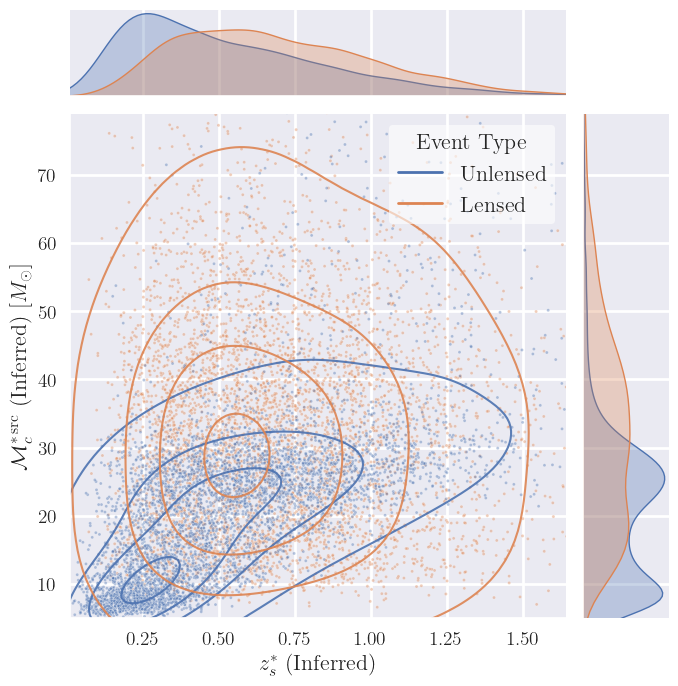

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from matplotlib.lines import Line2D

# Reset to defaults (optional but good if you've been tweaking rcParams a lot)
mpl.rcParams.update(mpl.rcParamsDefault)
LIGHT_BG = "#EAEAF2"
LEG_BG = "#E9EBF2"

# --- Seaborn grey background + white grid ---
sns.set_theme(
    style="darkgrid",   # grey background
    context="notebook",
    rc={
        # background
        "axes.facecolor": LIGHT_BG,   # seaborn-like grey
        "figure.facecolor": "white",
        # grid (white lines)
        "axes.grid": True,
        "grid.color": "white",
        "grid.linestyle": "-",
        "grid.linewidth": 2.0,
        "grid.alpha": 1.0,
        # keep grid behind artists
        "axes.axisbelow": True,
        # ticks (optional, helps readability on grey bg)
        "xtick.direction": "out",
        "ytick.direction": "out",
    }
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "custom",
    "savefig.dpi": 150, 
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
})

len_ = len(infrered_mc_unlensed)

# select random indices lensed
idx = np.random.choice(len(infrered_mc_lensed), size=len_, replace=False)
infrered_mc_lensed = infrered_mc_lensed[idx]
infrered_zs_lensed = infered_z_lensed[idx]

# setting up dataframe for seaborn
df_lensed = pd.DataFrame({
    'Infered $z_s$': infrered_zs_lensed,
    'Infered ${\\cal M}_c$ [$M_\\odot$]': infrered_mc_lensed,
    'Event Type': 'Lensed'
})
df_unlensed = pd.DataFrame({
    'Infered $z_s$': infered_z_unlensed,
    'Infered ${\\cal M}_c$ [$M_\\odot$]': infrered_mc_unlensed,
    'Event Type': 'Unlensed'
})
df_combined = pd.concat([df_lensed, df_unlensed], ignore_index=True)

contour_levels = np.sort(np.array([10, 40, 68, 95]) / 100)

# Keep jointplot (main + marginals) and avoid creating a separate empty figure
g = sns.jointplot(
    data=df_combined,
    x='Infered $z_s$',
    y='Infered ${\\cal M}_c$ [$M_\\odot$]',
    hue='Event Type',
    palette={'Unlensed': 'C0', 'Lensed': 'C1'},
    kind='scatter',
    alpha=0.4,
    joint_kws=dict(marker='.', alpha=1.0, s=20),
    height=7,
    marginal_kws={'alpha': 0.3, 'linewidth': 1.},
)

sns.kdeplot(
    data=df_combined[df_combined['Event Type'] == 'Unlensed'],
    x='Infered $z_s$',
    y='Infered ${\\cal M}_c$ [$M_\\odot$]',
    ax=g.ax_joint,
    levels=contour_levels,
    color='C0',
    alpha=0.9,
    linewidths=1.5,
    bw_adjust=1.8,
    fill=False,
)
sns.kdeplot(
    data=df_combined[df_combined['Event Type'] == 'Lensed'],
    x='Infered $z_s$',
    y='Infered ${\\cal M}_c$ [$M_\\odot$]',
    ax=g.ax_joint,
    levels=contour_levels,
    color='C1',
    alpha=0.9,
    linewidths=1.5,
    bw_adjust=1.8,
    fill=False,
)

g.set_axis_labels(r'$z^*_s$ (Inferred)', r'${\cal M}^{*\, {\rm src}}_c$ (Inferred) [$M_\odot$]', fontsize=16)
g.ax_joint.tick_params(axis='both', labelsize=14)
g.ax_marg_x.tick_params(axis='x', labelsize=14)
g.ax_marg_y.tick_params(axis='y', labelsize=14)

# legend
custom_handles = [
    Line2D([0], [0], color='C0', linestyle='-', linewidth=2.0, label='Unlensed'),
    Line2D([0], [0], color='C1', linestyle='-', linewidth=2.0, label='Lensed'),
]
leg1 = g.ax_joint.legend(handles=custom_handles, loc="upper right", handlelength=2, frameon=True, fontsize=16, title="Event Type", title_fontsize=16)
for h in leg1.get_lines():
    h.set_linewidth(2.0)
f1 = leg1.get_frame()
f1.set_facecolor('white')
f1.set_edgecolor("none")
f1.set_linewidth(0.0)
f1.set_alpha(0.6)

g.ax_joint.set_ylim(5, 79)
g.ax_joint.set_xlim(0.01, 1.65-0.01)

# save the figure if needed
plt.savefig('mc_vs_zs.png', bbox_inches='tight', dpi=150)
plt.show()

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

# without sns, with only corner plots
import corner
import matplotlib.lines as mlines

# Load data
unlensed_param = get_param_from_json('./ler_data/unlensed_BBH_O4.json')
unlensed_param_detectable = get_param_from_json('./ler_data/unlensed_detectable_BBH_O4.json')
lensed_param = get_param_from_json('./ler_data/lensed_BBH_O4.json')
lensed_param_detectable = get_param_from_json('./ler_data/lensed_detectable_BBH_O4.json')
lensed_param_intrinsic = get_param_from_json('./ler_data/lensed_intrinsic_BBH_O4.json')

In [15]:
from ler.utils import relative_mu_dt_unlensed, relative_mu_dt_lensed

chosen_idx = 10

# for unlensed detectable events
dmu_unlensed, dt_unlensed = relative_mu_dt_unlensed(size =5000, param=unlensed_param_detectable)

# for lensed detectable events
lensed_dict = relative_mu_dt_lensed(lensed_param=lensed_param_detectable)
dt_lensed = np.concatenate((lensed_dict['dt_rel0'], lensed_dict['dt_rel90']))
dmu_lensed = np.concatenate((lensed_dict['mu_rel0'], lensed_dict['mu_rel90']))

# keep only positive values before log10 to avoid -inf/nan in KDE
mask_u = (dmu_unlensed > 0) & (dt_unlensed > 0)
mask_l = (dmu_lensed > 0) & (dt_lensed > 0)

dmu_unlensed = np.log10(dmu_unlensed[mask_u])
dt_unlensed = np.log10(dt_unlensed[mask_u])
dmu_lensed = np.log10(dmu_lensed[mask_l])
dt_lensed = np.log10(dt_lensed[mask_l])

# chosen example index for 4 images, find time delays and magnifications
chosen_lens_dt = lensed_param_detectable['time_delays'][chosen_idx]
chosen_lens_mu = lensed_param_detectable['magnifications'][chosen_idx]

# make data frames for seaborn
df_u = pd.DataFrame({"x": dt_unlensed, "y": dmu_unlensed})
df_l = pd.DataFrame({"x": dt_lensed,   "y": dmu_lensed})

# remove any residual non-finite values
for df in (df_u, df_l):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=["x", "y"], inplace=True)

$$p(\Delta t) = p(\log_{10} \Delta t) \cdot \left| \frac{d(\log_{10} \Delta t)}{d(\Delta t)} \right| = \frac{p(\log_{10} \Delta t)}{\Delta t \cdot \ln 10}$$

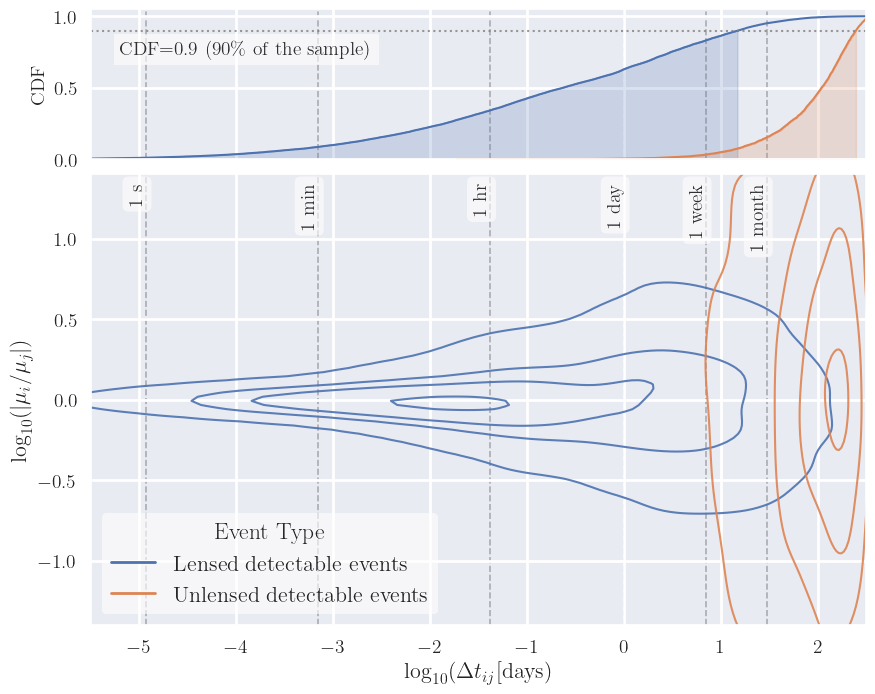

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# --- (Assuming df_l and df_u are already loaded from your previous steps) ---
# If you need to regenerate them, uncomment the data generation lines from your previous script.

# --- Plotting Setup ---
# Reset to defaults to ensure clean slate
mpl.rcParams.update(mpl.rcParamsDefault)
LIGHT_BG = "#E9EBF2"

sns.set_theme(
    style="darkgrid",
    context="notebook",
    rc={
        "axes.facecolor": LIGHT_BG,
        "figure.facecolor": "white",
        "axes.grid": True,
        "grid.color": "white",
        "grid.linestyle": "-",
        "grid.linewidth": 2.0,
        "grid.alpha": 1.0,
        "axes.axisbelow": True,
        "xtick.direction": "out",
        "ytick.direction": "out",
    }
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "custom",
    "savefig.dpi": 150,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "legend.title_fontsize": 17,
})

# --- Create Figure with GridSpec (Top: CDF, Bottom: Main) ---
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 3], hspace=0.05)

ax_cdf = fig.add_subplot(gs[0])
ax_main = fig.add_subplot(gs[1], sharex=ax_cdf)

# ----------------------------------
# --- 1. Top Panel: Marginal CDF ---
# ----------------------------------
# Helper to plot Empirical CDF with shading
def plot_ecdf_shaded(data, ax, color, label_prefix):
    # Sort data
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Plot the main line
    ax.plot(x, y, color=color, linewidth=1.5)
    
    # Mask for shading only where CDF < 0.9
    mask = y < 0.9
    
    # Shade the area
    ax.fill_between(
        x[mask], 
        y[mask], 
        color=color, 
        alpha=0.2, 
        step='post',  # 'step' makes it mathematically precise for ECDF
    )

# Plot Lensed (Blue)
plot_ecdf_shaded(df_l['x'], ax_cdf, 'C0', 'Lensed')

# Plot Unlensed (Orange)
plot_ecdf_shaded(df_u['x'], ax_cdf, 'C1', 'Unlensed')

# Add 0.9 threshold line
ax_cdf.axhline(0.9, color='gray', linestyle=':', linewidth=1.5, alpha=0.8)
ax_cdf.text(
    x=-5.2, # Position on the far left
    y=0.7, 
    s=r'CDF=0.9 (90\% of the sample)', 
    fontsize=14, 
    color='k',
    alpha=0.9,
    va='bottom',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

ax_cdf.set_ylabel("CDF", fontsize=14)
ax_cdf.set_ylim(0, 1.05)
ax_cdf.tick_params(labelbottom=False) 
ax_cdf.grid(True, color='white', linewidth=2.0)

# ----------------------------------------
# --- 2. Bottom Panel: Main 2D Contour ---
# ----------------------------------------
contour_levels = np.sort(np.array([10, 40, 68, 95])/100)

sns.kdeplot(
    data=df_l, x="x", y="y",
    fill=False, alpha=0.9, levels=contour_levels, bandwidth=2.0, color="C0", ax=ax_main,
)

sns.kdeplot(
    data=df_u, x="x", y="y",
    fill=False, alpha=0.9, levels=contour_levels, bandwidth=2.0, color="C1", ax=ax_main,
)

# --- Shared Annotations (Vertical Lines) ---
# We plot lines on both axes for visual continuity, but text only on the main one
time_markers_days = {
    '1 s': 1 / 86400,
    '1 min': 1 / 1440,
    '1 hr': 1 / 24,
    '1 day': 1,
    '1 week': 7,
    '1 month': 30,
}

for label, time_in_days in time_markers_days.items():
    xline = np.log10(time_in_days)
    # Line on Main Plot
    ax_main.axvline(x=xline, color='k', linestyle='--', linewidth=1.2, alpha=0.3, zorder=0)
    # Line on CDF Plot
    ax_cdf.axvline(x=xline, color='k', linestyle='--', linewidth=1.2, alpha=0.3, zorder=0)
    # Text with box on Main Plot
    ax_main.text(
        xline, 1.35, label, 
        rotation=90, va='top', ha='right', 
        fontsize=14, color='k', alpha=0.9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
    )

# --- Axis Labels & Limits ---
ax_main.set_xlabel(r'$\log_{10}(\Delta t_{ij}  [{\rm days})$')
ax_main.set_ylabel(r'$\log_{10}(|\mu_i / \mu_j|)$')
ax_main.set_xlim(-5.5, 2.5)
ax_main.set_ylim(-1.4, 1.4)

# --- Legend (Preserved Exactly) ---
custom_handles = [
    Line2D([0], [0], color='C0', linestyle='-', linewidth=2.0, label='Lensed detectable events'),
    Line2D([0], [0], color='C1', linestyle='-', linewidth=2.0, label='Unlensed detectable events'),
]
leg1 = ax_main.legend(handles=custom_handles, loc="lower left", handlelength=2, frameon=True, fontsize=16, title="Event Type", title_fontsize=17)
for h in leg1.get_lines():
    h.set_linewidth(2.0)
f1 = leg1.get_frame()
f1.set_facecolor('white')
f1.set_edgecolor("none")
f1.set_linewidth(0.0)
f1.set_alpha(0.6)

# save the figure if needed
plt.savefig('dt_vs_dmu.png', bbox_inches='tight', dpi=150)

plt.show()

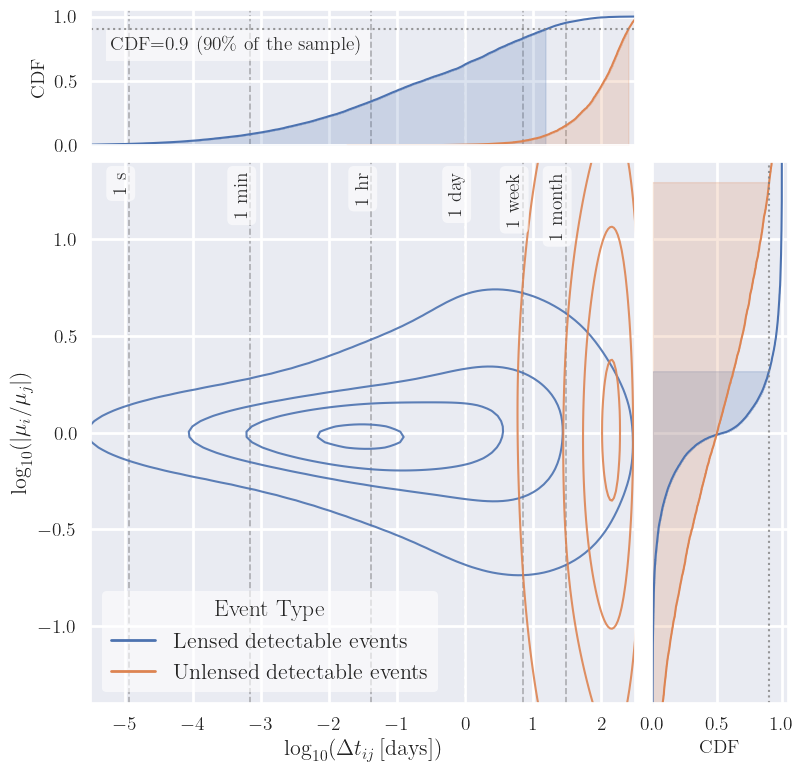

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# --- (Assuming df_l and df_u are already loaded from your previous steps) ---
# If you need to regenerate them, uncomment the data generation lines from your previous script.
# For testing purposes, uncomment below:
# np.random.seed(42)
# df_l = pd.DataFrame({'x': np.random.normal(0, 1, 1000), 'y': np.random.normal(0, 0.5, 1000)})
# df_u = pd.DataFrame({'x': np.random.normal(1, 1.2, 1000), 'y': np.random.normal(0, 0.3, 1000)})

# --- Plotting Setup ---
mpl.rcParams.update(mpl.rcParamsDefault)
LIGHT_BG = "#E9EBF2"

sns.set_theme(
    style="darkgrid",
    context="notebook",
    rc={
        "axes.facecolor": LIGHT_BG,
        "figure.facecolor": "white",
        "axes.grid": True,
        "grid.color": "white",
        "grid.linestyle": "-",
        "grid.linewidth": 2.0,
        "grid.alpha": 1.0,
        "axes.axisbelow": True,
        "xtick.direction": "out",
        "ytick.direction": "out",
    }
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "custom",
    "savefig.dpi": 150,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "legend.title_fontsize": 17,
})

# --- Create Figure with 2x2 GridSpec ---
# Change figsize to a square so width_ratios and height_ratios yield equal physical sizes
fig = plt.figure(figsize=(9, 9)) 

# Set equal ratios for width and height to ensure the marginal panels are the same size
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Assign axes to the GridSpec cells
ax_cdf_x = fig.add_subplot(gs[0, 0])
ax_main = fig.add_subplot(gs[1, 0], sharex=ax_cdf_x)
ax_cdf_y = fig.add_subplot(gs[1, 1], sharey=ax_main)
# gs[0, 1] is intentionally left empty

# ---------------------------------------------------
# --- Helper: Plot Empirical CDF with shading     ---
# ---------------------------------------------------
def plot_ecdf_shaded(data, ax, color, label_prefix, orientation='vertical'):
    # Sort data
    val = np.sort(data)
    cdf = np.arange(1, len(val) + 1) / len(val)
    mask = cdf < 0.9
    
    if orientation == 'vertical':
        # Plots CDF on the y-axis (for the top panel)
        ax.plot(val, cdf, color=color, linewidth=1.5)
        ax.fill_between(
            val[mask], 
            cdf[mask], 
            color=color, 
            alpha=0.2, 
            step='post'
        )
    elif orientation == 'horizontal':
        # Plots CDF on the x-axis (for the right panel)
        ax.plot(cdf, val, color=color, linewidth=1.5)
        ax.fill_betweenx(
            val[mask], 
            0, 
            cdf[mask], 
            color=color, 
            alpha=0.2, 
            step='post'
        )

# ----------------------------------
# --- 1. Top Panel: Marginal CDF X ---
# ----------------------------------
plot_ecdf_shaded(df_l['x'], ax_cdf_x, 'C0', 'Lensed', orientation='vertical')
plot_ecdf_shaded(df_u['x'], ax_cdf_x, 'C1', 'Unlensed', orientation='vertical')

ax_cdf_x.axhline(0.9, color='gray', linestyle=':', linewidth=1.5, alpha=0.8)
ax_cdf_x.text(
    x=-5.2, 
    y=0.7, 
    s=r'CDF=0.9 (90\% of the sample)', 
    fontsize=14, 
    color='k',
    alpha=0.9,
    va='bottom',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

ax_cdf_x.set_ylabel("CDF", fontsize=14)
ax_cdf_x.set_ylim(0, 1.05)
ax_cdf_x.set_yticks([0, 0.5, 1])
ax_cdf_x.tick_params(labelbottom=False) 
ax_cdf_x.grid(True, color='white', linewidth=2.0)

# ----------------------------------------
# --- 2. Bottom Panel: Main 2D Contour ---
# ----------------------------------------
contour_levels = np.sort(np.array([10, 40, 68, 95])/100)

sns.kdeplot(
    data=df_l, x="x", y="y",
    fill=False, alpha=0.9, levels=contour_levels, bw_adjust=2.0, color="C0", ax=ax_main,
)

sns.kdeplot(
    data=df_u, x="x", y="y",
    fill=False, alpha=0.9, levels=contour_levels, bw_adjust=2.0, color="C1", ax=ax_main,
)

# Shared Annotations (Vertical Lines)
time_markers_days = {
    '1 s': 1 / 86400,
    '1 min': 1 / 1440,
    '1 hr': 1 / 24,
    '1 day': 1,
    '1 week': 7,
    '1 month': 30,
}

for label, time_in_days in time_markers_days.items():
    xline = np.log10(time_in_days)
    ax_main.axvline(x=xline, color='k', linestyle='--', linewidth=1.2, alpha=0.3, zorder=0)
    ax_cdf_x.axvline(x=xline, color='k', linestyle='--', linewidth=1.2, alpha=0.3, zorder=0)
    
    # Adjust y position of text slightly due to square figure shape
    ax_main.text(
        xline, 1.35, label, 
        rotation=90, va='top', ha='right', 
        fontsize=14, color='k', alpha=0.9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
    )

ax_main.set_xlabel(r'$\log_{10}(\Delta t_{ij}\,  [{\rm days}])$')
ax_main.set_ylabel(r'$\log_{10}(|\mu_i / \mu_j|)$')
ax_main.set_xlim(-5.5, 2.5)
ax_main.set_ylim(-1.4, 1.4)

# ------------------------------------
# --- 3. Right Panel: Marginal CDF Y ---
# ------------------------------------
plot_ecdf_shaded(df_l['y'], ax_cdf_y, 'C0', 'Lensed', orientation='horizontal')
plot_ecdf_shaded(df_u['y'], ax_cdf_y, 'C1', 'Unlensed', orientation='horizontal')

ax_cdf_y.axvline(0.9, color='gray', linestyle=':', linewidth=1.5, alpha=0.8)

ax_cdf_y.set_xlabel("CDF", fontsize=14)
ax_cdf_y.set_xlim(0, 1.05)
ax_cdf_y.set_xticks([0, 0.5, 1])
ax_cdf_y.tick_params(labelleft=False) 
ax_cdf_y.grid(True, color='white', linewidth=2.0)

# --- Legend (Preserved Exactly) ---
custom_handles = [
    Line2D([0], [0], color='C0', linestyle='-', linewidth=2.0, label='Lensed detectable events'),
    Line2D([0], [0], color='C1', linestyle='-', linewidth=2.0, label='Unlensed detectable events'),
]
leg1 = ax_main.legend(handles=custom_handles, loc="lower left", handlelength=2, frameon=True, fontsize=16, title="Event Type", title_fontsize=17)
for h in leg1.get_lines():
    h.set_linewidth(2.0)
f1 = leg1.get_frame()
f1.set_facecolor('white')
f1.set_edgecolor("none")
f1.set_linewidth(0.0)
f1.set_alpha(0.6)

plt.savefig('dt_vs_dmu.png', bbox_inches='tight', dpi=150)
plt.show()

In [55]:
import numpy as np

def get_value_at_cdf(data, target_cdf=0.9):
    """
    Returns the value in 'data' below which 'target_cdf' fraction of points lie.
    """
    sorted_data = np.sort(data)
    # Find the index corresponding to the target percentile
    idx = int(target_cdf * len(sorted_data))
    # Ensure index is within bounds
    idx = min(idx, len(sorted_data) - 1)
    return sorted_data[idx]

# --- 1. Calculate Thresholds for Time Delay (x axis) ---
# Lensed
log_dt_l_90 = get_value_at_cdf(df_l['x'], 0.9)
dt_l_90_days = 10**log_dt_l_90

# Format lensed time nicely (it can be very short)
if dt_l_90_days < 1/1440:       # < 1 min
    dt_l_str = f"{dt_l_90_days*86400:.2f} seconds"
elif dt_l_90_days < 1/24:       # < 1 hour
    dt_l_str = f"{dt_l_90_days*1440:.2f} minutes"
elif dt_l_90_days < 1:          # < 1 day
    dt_l_str = f"{dt_l_90_days*24:.2f} hours"
else:
    dt_l_str = f"{dt_l_90_days:.2f} days"

# Unlensed
log_dt_u_90 = get_value_at_cdf(df_u['x'], 0.9)
dt_u_90_days = 10**log_dt_u_90

# Format unlensed time nicely (it can be very short)
if dt_u_90_days < 1/1440:       # < 1 min
    dt_u_str = f"{dt_u_90_days*86400:.2f} seconds"
elif dt_u_90_days < 1/24:       # < 1 hour
    dt_u_str = f"{dt_u_90_days*1440:.2f} minutes"
elif dt_u_90_days < 1:          # < 1 day
    dt_u_str = f"{dt_u_90_days*24:.2f} hours"
else:
    dt_u_str = f"{dt_u_90_days:.2f} days"

# --- 2. Calculate Thresholds for Magnification Ratio (y axis) ---
# Lensed
log_mu_l_90 = get_value_at_cdf(df_l['y'], 0.9)
mu_l_90 = 10**log_mu_l_90

# Unlensed
log_mu_u_90 = get_value_at_cdf(df_u['y'], 0.9)
mu_u_90 = 10**log_mu_u_90

# --- 3. Print Results ---
print("=" * 50)
print(f"90% Confidence Intervals (CDF = 0.9)")
print("=" * 50)

print(f"LENSED Events:")
print(f"  • 90% have time delay < {dt_l_str}")
print(f"    (log10(dt) < {log_dt_l_90:.3f})")
print(f"  • 90% have mag ratio  < {mu_l_90:.3f}")
print(f"    (log10(mu) < {log_mu_l_90:.3f})")

print("-" * 50)

print(f"UNLENSED Events:")
print(f"  • 90% have time delay < {dt_u_str}")
print(f"    (log10(dt) < {log_dt_u_90:.3f})")
print(f"  • 90% have mag ratio  < {mu_u_90:.3f}")
print(f"    (log10(mu) < {log_mu_u_90:.3f})")
print("=" * 50)

90% Confidence Intervals (CDF = 0.9)
LENSED Events:
  • 90% have time delay < 15.09 days
    (log10(dt) < 1.179)
  • 90% have mag ratio  < 2.081
    (log10(mu) < 0.318)
--------------------------------------------------
UNLENSED Events:
  • 90% have time delay < 244.28 days
    (log10(dt) < 2.388)
  • 90% have mag ratio  < 17.282
    (log10(mu) < 1.238)


In [27]:
np.log10(0.55)

np.float64(-0.2596373105057561)